## Imports

In [1]:
import pandas as pd
import geopandas as gpd
import folium
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

## Bring in our two files to join for time comparison.  

We want to look at the change in population per age group, as well as share of total population per age group, between the two five year periods represented by the American Community Survey 5-Year estimates. Here that's 2010-2014, and 2015-2019. We're going to bring in the 2014 file and rename the columns so that it's clear which is the older set - but I'm not going to specify the year so that this code can be reused with minimal changes when the next 5 year estimates come out. I'm going to bring in the 2019 csv as well. We can create a geodataframe later if we want.

In [74]:
# 2019 shapefile
new = pd.read_csv('../output/csv/agegroupsnogender_2019_cbsa.csv')

In [75]:
#2014 csv
old = pd.read_csv('../output/csv/agegroupsnogender_2014_cbsa.csv')

In [76]:
new.head(3)

,CBSA,GEOID,CBSAFIPS,total,U5,school,18_20s,30s,40s,50_65,O65,PU5,Pschool,P18_20s,P30s,P40s,P50_65,PO65
0,"Big Stone Gap, VA Micro Area",310M500US13720,13720,42456,2214,6189,6933,5337,5350,8976,7457,5.2,14.6,16.3,12.6,12.6,21.1,17.6
1,"Billings, MT Metro Area",310M500US13740,13740,179071,10811,30624,25857,23260,21387,36130,31002,6.0,17.1,14.4,13.0,11.9,20.2,17.3
2,"Binghamton, NY Metro Area",310M500US13780,13780,241874,12580,35319,44875,26009,25965,51415,45711,5.2,14.6,18.6,10.8,10.7,21.3,18.9


In [77]:
new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 938 entries, 0 to 937
Data columns (total 18 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   CBSA      938 non-null    object 
 1   GEOID     938 non-null    object 
 2   CBSAFIPS  938 non-null    int64  
 3   total     938 non-null    int64  
 4   U5        938 non-null    int64  
 5   school    938 non-null    int64  
 6   18_20s    938 non-null    int64  
 7   30s       938 non-null    int64  
 8   40s       938 non-null    int64  
 9   50_65     938 non-null    int64  
 10  O65       938 non-null    int64  
 11  PU5       938 non-null    float64
 12  Pschool   938 non-null    float64
 13  P18_20s   938 non-null    float64
 14  P30s      938 non-null    float64
 15  P40s      938 non-null    float64
 16  P50_65    938 non-null    float64
 17  PO65      938 non-null    float64
dtypes: float64(7), int64(9), object(2)
memory usage: 132.0+ KB


Before joining, look at the older file and add a tag to the column names - the groups are the same so this will allow us to tell them apart when we calculate our time series.

In [78]:
old.head(3)

,CBSA,GEOID,CBSAFIPS,total,U5,school,18_20s,30s,40s,50_65,O65,PU5,Pschool,P18_20s,P30s,P40s,P50_65,PO65
0,"Homosassa Springs, FL Metro Area",310M200US26140,26140,139771,5432,16056,13331,10585,14630,32784,46953,3.9,11.5,9.5,7.6,10.5,23.5,33.6
1,"Hickory-Lenoir-Morganton, NC Metro Area",310M200US25860,25860,363936,20102,60758,50605,43272,53505,76741,58953,5.5,16.7,13.9,11.9,14.7,21.1,16.2
2,"Hobbs, NM Micro Area",310M200US26020,26020,66876,5790,14142,11683,9115,7799,11186,7161,8.7,21.1,17.5,13.6,11.7,16.7,10.7


In [79]:
old.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 929 entries, 0 to 928
Data columns (total 18 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   CBSA      929 non-null    object 
 1   GEOID     929 non-null    object 
 2   CBSAFIPS  929 non-null    int64  
 3   total     929 non-null    int64  
 4   U5        929 non-null    int64  
 5   school    929 non-null    int64  
 6   18_20s    929 non-null    int64  
 7   30s       929 non-null    int64  
 8   40s       929 non-null    int64  
 9   50_65     929 non-null    int64  
 10  O65       929 non-null    int64  
 11  PU5       929 non-null    float64
 12  Pschool   929 non-null    float64
 13  P18_20s   929 non-null    float64
 14  P30s      929 non-null    float64
 15  P40s      929 non-null    float64
 16  P50_65    929 non-null    float64
 17  PO65      929 non-null    float64
dtypes: float64(7), int64(9), object(2)
memory usage: 130.8+ KB


In [80]:
#for loop for renaming them with an O* for old at the beginning of each column
for col in old.columns:
    old.rename(columns = {col:'O*'+col}, inplace = True)

In [81]:
#check that this was effective
old.head(3)

,O*CBSA,O*GEOID,O*CBSAFIPS,O*total,O*U5,O*school,O*18_20s,O*30s,O*40s,O*50_65,O*O65,O*PU5,O*Pschool,O*P18_20s,O*P30s,O*P40s,O*P50_65,O*PO65
0,"Homosassa Springs, FL Metro Area",310M200US26140,26140,139771,5432,16056,13331,10585,14630,32784,46953,3.9,11.5,9.5,7.6,10.5,23.5,33.6
1,"Hickory-Lenoir-Morganton, NC Metro Area",310M200US25860,25860,363936,20102,60758,50605,43272,53505,76741,58953,5.5,16.7,13.9,11.9,14.7,21.1,16.2
2,"Hobbs, NM Micro Area",310M200US26020,26020,66876,5790,14142,11683,9115,7799,11186,7161,8.7,21.1,17.5,13.6,11.7,16.7,10.7


In [82]:
#rename the O*GEOID to the reverted column name to join on it
old = old.rename(columns = {'O*GEOID':'GEOID', 'O*CBSA':'CBSA'})

Now we can join the old df onto the new geodataframe

In [83]:
new['GEOID'] = new['GEOID'].astype(str)
old['GEOID'] = old['GEOID'].astype(str)
new['CBSA'] = new['CBSA'].astype(str)
old['CBSA'] = old['CBSA'].astype(str)

In [84]:
cbsa = pd.merge(new, old, on='CBSA', how = 'inner')

In [85]:
cbsa.head()

,CBSA,GEOID_x,CBSAFIPS,total,U5,school,18_20s,30s,40s,50_65,...,O*40s,O*50_65,O*O65,O*PU5,O*Pschool,O*P18_20s,O*P30s,O*P40s,O*P50_65,O*PO65
0,"Big Stone Gap, VA Micro Area",310M500US13720,13720,42456,2214,6189,6933,5337,5350,8976,...,8379,12926,9324,5.3,15.1,16.1,12.8,13.8,21.4,15.4
1,"Billings, MT Metro Area",310M500US13740,13740,179071,10811,30624,25857,23260,21387,36130,...,20400,34472,24642,6.5,16.8,15.2,12.7,12.5,21.2,15.1
2,"Binghamton, NY Metro Area",310M500US13780,13780,241874,12580,35319,44875,26009,25965,51415,...,30782,53366,42140,5.2,15.2,18.3,10.7,12.3,21.4,16.9
3,"Birmingham-Hoover, AL Metro Area",310M500US13820,13820,1085330,67638,182860,168169,144073,140593,213217,...,155983,227967,155901,6.5,17.1,15.7,13.2,13.7,20.1,13.7
4,"Bismarck, ND Metro Area",310M500US13900,13900,127503,8528,20643,20699,18413,14349,24697,...,14746,24346,16893,6.7,16.5,17.3,13.2,12.2,20.2,14.0


In [86]:
cbsa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 859 entries, 0 to 858
Data columns (total 35 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CBSA        859 non-null    object 
 1   GEOID_x     859 non-null    object 
 2   CBSAFIPS    859 non-null    int64  
 3   total       859 non-null    int64  
 4   U5          859 non-null    int64  
 5   school      859 non-null    int64  
 6   18_20s      859 non-null    int64  
 7   30s         859 non-null    int64  
 8   40s         859 non-null    int64  
 9   50_65       859 non-null    int64  
 10  O65         859 non-null    int64  
 11  PU5         859 non-null    float64
 12  Pschool     859 non-null    float64
 13  P18_20s     859 non-null    float64
 14  P30s        859 non-null    float64
 15  P40s        859 non-null    float64
 16  P50_65      859 non-null    float64
 17  PO65        859 non-null    float64
 18  GEOID_y     859 non-null    object 
 19  O*CBSAFIPS  859 non-null    i

# Now we start thinking about the kinds of change we want to look at.

With the measures I think the two most sensical ways to look at things are: percent change in the raw numbers, and change in population share.

## Percent change, limited to 65+, u18, and the rest as one group aka "tax base".

First add up the tax base group:

In [87]:
cbsa['O*child'] = cbsa['O*U5']+cbsa['O*school']
cbsa['child'] = cbsa['U5']+cbsa['school']
cbsa['O*taxbase'] = cbsa['O*18_20s']+cbsa['O*30s']+cbsa['O*40s']+cbsa['O*50_65']
cbsa['taxbase'] = cbsa['18_20s']+cbsa['30s']+cbsa['40s']+cbsa['50_65']

In [88]:
cbsa['elderlypercchange'] = round((cbsa['O65'] - cbsa['O*O65'])*100/cbsa['O*O65'], 2)
cbsa['taxbasepercchange'] = round((cbsa['taxbase'] - cbsa['O*taxbase'])*100/cbsa['O*taxbase'], 2)
cbsa['childpercchange'] = round((cbsa['child'] - cbsa['O*child'])*100/cbsa['O*child'], 2)
cbsa['totalpercchange'] = round((cbsa['total']-cbsa['O*total'])*100/cbsa['O*total'], 2)

## Change in population share for our same three groups

Probably move these calculations to the first files and just export groups eventually for the entire project.... gonna finish this for now brain melting.

In [102]:
cbsa['O*Pchild'] = cbsa['O*PU5'] + cbsa['O*Pschool']
cbsa['Pchild'] = cbsa['PU5'] + cbsa['Pschool']
cbsa['O*Ptaxbase'] = cbsa['O*P18_20s']+cbsa['O*P30s']+cbsa['O*P40s']+cbsa['O*P50_65']
cbsa['Ptaxbase'] = cbsa['P18_20s']+cbsa['P30s']+cbsa['P40s']+cbsa['P50_65']

cbsa['elderlysharechange'] = cbsa['PO65'] - cbsa['O*PO65']
cbsa['tbsharechange'] = cbsa['Ptaxbase'] - cbsa['O*Ptaxbase']
cbsa['childsharechange'] = cbsa['Pchild'] - cbsa['O*Pchild']
cbsa['elderlyrealchange'] = cbsa['O65'] - cbsa['O*O65']
cbsa['tbrealchange'] = cbsa['taxbase'] - cbsa['O*taxbase']
cbsa['childrealchange'] = cbsa['child'] - cbsa['O*child']
cbsa['totalrealchange'] = cbsa['total'] - cbsa['O*total']

In [103]:
#make another small dataframe to check out high and low values, who's around the Nashville MSA... etc.
data = cbsa[['CBSA', 'GEOID_x', 'CBSAFIPS','elderlypercchange',
                  'taxbasepercchange', 'childpercchange', 'totalpercchange', 
                  'elderlysharechange', 'tbsharechange', 'childsharechange', 
                 'elderlyrealchange', 'tbrealchange', 'childrealchange', 'totalrealchange', 'O*child', 'child', 
                 'O*taxbase', 'taxbase', 'O*O65', 'O65', 'O*total', 'total']]

In [104]:
data.head()

,CBSA,GEOID_x,CBSAFIPS,elderlypercchange,taxbasepercchange,childpercchange,totalpercchange,elderlysharechange,tbsharechange,childsharechange,...,childrealchange,totalrealchange,O*child,child,O*taxbase,taxbase,O*O65,O65,O*total,total
0,"Big Stone Gap, VA Micro Area",310M500US13720,13720,-20.02,-31.45,-32.10,-29.82,2.2,-1.5,-0.6,...,-3972,-18043,12375,8403,38800,26596,9324,7457,60499,42456
1,"Billings, MT Metro Area",310M500US13740,13740,25.81,6.34,9.11,9.93,2.2,-2.1,-0.2,...,3461,16179,37974,41435,100276,106634,24642,31002,162892,179071
2,"Binghamton, NY Metro Area",310M500US13780,13780,8.47,-5.16,-5.71,-2.96,2.0,-1.3,-0.6,...,-2899,-7387,50798,47899,156323,148264,42140,45711,249261,241874
3,"Birmingham-Hoover, AL Metro Area",310M500US13820,13820,8.26,-6.46,-6.40,-4.42,1.9,-1.3,-0.6,...,-17116,-50204,267614,250498,712019,666052,155901,168780,1135534,1085330
4,"Bismarck, ND Metro Area",310M500US13900,13900,19.42,3.07,4.31,5.65,1.8,-1.6,-0.3,...,1205,6815,27966,29171,75829,78158,16893,20174,120688,127503


In [105]:
#index into where the Nashville MSA is to check the rankings out
nash = groupperc.loc[groupperc['CBSA'] == 'Nashville-Davidson--Murfreesboro--Franklin, TN Metro Area'].reset_index(drop = True)

In [106]:
print("The following numbers are Nashville's elderly population from the 2014 5Yr estimates, 2019, then the percent growth in a 5 year over 5 year period for total elderly population, then the share change between the 2014 and 2019 periods:")
print('______________________________________________________________________________')
print(nash['O*O65'])
print(nash['O65'])
print(nash['elderlypercchange'])
print(nash['elderlysharechange'])
print("The following number are Nashville's tax base population from the 2014 5Yr estimates, 2019, then the percent growth in a 5 year over 5 year period for total tax base population, then the share change between the 2014 and 2019 periods:")
print('______________________________________________________________________________')
print(nash['O*taxbase'])
print(nash['taxbase'])
print(nash['taxbasepercchange'])
print(nash['tbsharechange'])
print("The following number are Nashville's child population from the 2014 5Yr estimates, 2019, then the percent growth in a 5 year over 5 year period for total child population, then the share change between the 2014 and 2019 periods:")
print('______________________________________________________________________________')
print(nash['O*child'])
print(nash['child'])
print(nash['childpercchange'])
print(nash['childsharechange'])

The following numbers are Nashville's elderly population from the 2014 5Yr estimates, 2019, then the percent growth in a 5 year over 5 year period for total elderly population, then the share change between the 2014 and 2019 periods:
______________________________________________________________________________
0    199008
Name: O*O65, dtype: int64
0    242225
Name: O65, dtype: int64
0    21.72
Name: elderlypercchange, dtype: float64
0    1.4
Name: elderlysharechange, dtype: float64
The following number are Nashville's tax base population from the 2014 5Yr estimates, 2019, then the percent growth in a 5 year over 5 year period for total tax base population, then the share change between the 2014 and 2019 periods:
______________________________________________________________________________
0    1115722
Name: O*taxbase, dtype: int64
0    1193526
Name: taxbase, dtype: int64
0    6.97
Name: taxbasepercchange, dtype: float64
0   -0.7
Name: tbsharechange, dtype: float64
The following numbe

In [114]:
data.corr()

,CBSAFIPS,elderlypercchange,taxbasepercchange,childpercchange,totalpercchange,elderlysharechange,tbsharechange,childsharechange,elderlyrealchange,tbrealchange,childrealchange,totalrealchange,O*child,child,O*taxbase,taxbase,O*O65,O65,O*total,total
CBSAFIPS,1.000000,-0.042978,-0.036769,-0.020528,-0.029995,0.022080,-0.045155,0.028565,0.014809,-0.011332,-0.002607,-0.001689,0.011502,0.011682,0.013170,0.012653,0.019732,0.019199,0.013635,0.013404
elderlypercchange,-0.042978,1.000000,0.846605,0.734001,0.878040,0.387301,-0.163541,-0.273503,0.123522,0.186138,0.136473,0.213064,0.046059,0.055544,0.043709,0.052573,0.033878,0.046532,0.043099,0.052483
taxbasepercchange,-0.036769,0.846605,1.000000,0.900428,0.987418,-0.056927,0.156218,-0.105607,0.129256,0.231541,0.169344,0.254402,0.060872,0.072750,0.055043,0.066070,0.046862,0.058610,0.055482,0.066643
childpercchange,-0.020528,0.734001,0.900428,1.000000,0.930825,-0.166048,-0.103778,0.306397,0.081945,0.214673,0.202455,0.232782,0.018018,0.030620,0.014058,0.024230,0.005084,0.015753,0.013879,0.024503
totalpercchange,-0.029995,0.878040,0.987418,0.930825,1.000000,0.033986,0.006756,-0.048008,0.120823,0.226208,0.178600,0.250025,0.043803,0.055734,0.039709,0.050462,0.034104,0.046355,0.040037,0.051167
elderlysharechange,0.022080,0.387301,-0.056927,-0.166048,0.033986,1.000000,-0.606549,-0.499081,0.000507,-0.058866,-0.041868,-0.049955,-0.050987,-0.054973,-0.042124,-0.044967,-0.025093,-0.021740,-0.042131,-0.043974
tbsharechange,-0.045155,-0.163541,0.156218,-0.103778,0.006756,-0.606549,1.000000,-0.377470,0.090347,0.088945,-0.023760,0.089385,0.125878,0.128135,0.112106,0.116470,0.097296,0.097064,0.113683,0.116552
childsharechange,0.028565,-0.273503,-0.105607,0.306397,-0.048008,-0.499081,-0.377470,1.000000,-0.105623,-0.025559,0.082527,-0.037953,-0.084565,-0.082111,-0.080405,-0.081726,-0.084051,-0.087666,-0.081999,-0.082840
elderlyrealchange,0.014809,0.123522,0.129256,0.081945,0.120823,0.000507,0.090347,-0.105623,1.000000,0.190229,-0.343985,0.453359,0.963563,0.971172,0.957731,0.968073,0.937359,0.953056,0.958339,0.968627
tbrealchange,-0.011332,0.186138,0.231541,0.214673,0.226208,-0.058866,0.088945,-0.025559,0.190229,1.000000,0.781836,0.954873,-0.003702,0.042826,-0.053311,-0.006094,-0.135589,-0.091539,-0.052166,-0.007367


## Bring in shapefile to join

In [115]:
#extract GeoDataFrame from Tiger
url= 'https://www2.census.gov/geo/tiger/TIGER2019/CBSA/tl_2019_us_cbsa.zip'
cbsa = gpd.read_file(url)
cbsa.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 938 entries, 0 to 937
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   CSAFP     550 non-null    object  
 1   CBSAFP    938 non-null    object  
 2   GEOID     938 non-null    object  
 3   NAME      938 non-null    object  
 4   NAMELSAD  938 non-null    object  
 5   LSAD      938 non-null    object  
 6   MEMI      938 non-null    object  
 7   MTFCC     938 non-null    object  
 8   ALAND     938 non-null    int64   
 9   AWATER    938 non-null    int64   
 10  INTPTLAT  938 non-null    object  
 11  INTPTLON  938 non-null    object  
 12  geometry  938 non-null    geometry
dtypes: geometry(1), int64(2), object(10)
memory usage: 95.4+ KB


In [116]:
cbsa.head(3)

,CSAFP,CBSAFP,GEOID,NAME,NAMELSAD,LSAD,MEMI,MTFCC,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,122,12020,12020,"Athens-Clarke County, GA","Athens-Clarke County, GA Metro Area",M1,1,G3110,2654601832,26140309,+33.9439840,-083.2138965,"POLYGON ((-83.53739 33.96591, -83.53184 33.968..."
1,122,12060,12060,"Atlanta-Sandy Springs-Alpharetta, GA","Atlanta-Sandy Springs-Alpharetta, GA Metro Area",M1,1,G3110,22494938651,387716575,+33.6937280,-084.3999113,"POLYGON ((-85.33823 33.65312, -85.33842 33.654..."
2,428,12100,12100,"Atlantic City-Hammonton, NJ","Atlantic City-Hammonton, NJ Metro Area",M1,1,G3110,1438776649,301268696,+39.4693555,-074.6337591,"POLYGON ((-74.85675 39.42076, -74.85670 39.420..."


In [117]:
cbsa['CBSAFP'] = cbsa['CBSAFP'].astype(int)
data['CBSAFIPS'] = data['CBSAFIPS'].astype(int)

In [118]:
data_geo = cbsa.merge(data, left_on='CBSAFP', right_on='CBSAFIPS')

In [119]:
data_geo.head()

,CSAFP,CBSAFP,GEOID,NAME,NAMELSAD,LSAD,MEMI,MTFCC,ALAND,AWATER,...,childrealchange,totalrealchange,O*child,child,O*taxbase,taxbase,O*O65,O65,O*total,total
0,122,12020,12020,"Athens-Clarke County, GA","Athens-Clarke County, GA Metro Area",M1,1,G3110,2654601832,26140309,...,2087,12170,40035,42122,134788,139587,21464,26748,196287,208457
1,428,12100,12100,"Atlantic City-Hammonton, NJ","Atlantic City-Hammonton, NJ Metro Area",M1,1,G3110,1438776649,301268696,...,-5234,-9220,62319,57085,171849,162363,41157,46657,275325,266105
2,258,12140,12140,"Auburn, IN","Auburn, IN Micro Area",M2,2,G3110,939731962,2657419,...,-308,606,10780,10472,25634,25677,5907,6778,42321,42927
3,532,12180,12180,"Auburn, NY","Auburn, NY Micro Area",M2,2,G3110,1791190510,445708165,...,-1268,-2056,16662,15394,49973,47819,12846,14212,79481,77425
4,194,12220,12220,"Auburn-Opelika, AL","Auburn-Opelika, AL Metro Area",M1,1,G3110,1573514768,21526461,...,1908,13362,32480,34388,101046,108068,14264,18696,147790,161152


In [120]:
data_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 859 entries, 0 to 858
Data columns (total 35 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   CSAFP               497 non-null    object  
 1   CBSAFP              859 non-null    int32   
 2   GEOID               859 non-null    object  
 3   NAME                859 non-null    object  
 4   NAMELSAD            859 non-null    object  
 5   LSAD                859 non-null    object  
 6   MEMI                859 non-null    object  
 7   MTFCC               859 non-null    object  
 8   ALAND               859 non-null    int64   
 9   AWATER              859 non-null    int64   
 10  INTPTLAT            859 non-null    object  
 11  INTPTLON            859 non-null    object  
 12  geometry            859 non-null    geometry
 13  CBSA                859 non-null    object  
 14  GEOID_x             859 non-null    object  
 15  CBSAFIPS            859 non-null

In [121]:
data_geo = data_geo.drop(columns = ['CSAFP', 'CBSAFP', 'GEOID', 'NAME', 'NAMELSAD', 'MEMI', 'MTFCC', 'INTPTLAT', 
                                    'INTPTLON'])

In [122]:
data_geo = data_geo.rename(columns={'LSAD':'Micro_Metro','GEOID_x':'GEOID'})

###### Convert land and water areas to proper units.

We have this in square meters, so the converstion factor is 0.0000003861 to get this to square miles.

In [123]:
data_geo['ALAND'] = data_geo['ALAND'] * 0.0000003861
data_geo['AWATER'] = data_geo['AWATER'] * 0.0000003861

In [127]:
data_geo['popdensity14'] = data_geo['O*total']/data_geo['ALAND']
data_geo['popdensity19'] = data_geo['O*total']/data_geo['ALAND']
data_geo['elderlypopdensity14'] = data_geo['O*O65']/data_geo['ALAND']
data_geo['elderlypopdensity19'] = data_geo['O65']/data_geo['ALAND']
data_geo['tbdensity14'] = data_geo['O*taxbase']/data_geo['ALAND']
data_geo['tbdensity19'] = data_geo['taxbase']/data_geo['ALAND']
data_geo['childdensity14'] = data_geo['O*child']/data_geo['ALAND']
data_geo['childdensity19'] = data_geo['child']/data_geo['ALAND']

### Check out our Distributions

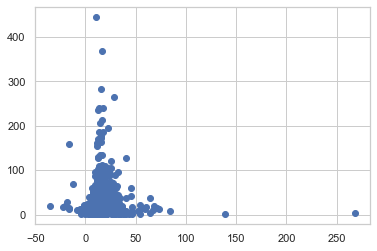

In [131]:
plt.scatter(data_geo['elderlypercchange'], data_geo['elderlypopdensity19'])

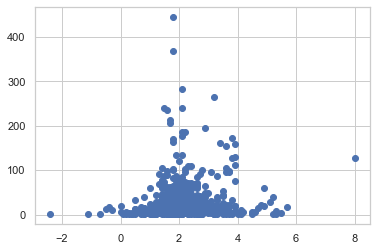

In [142]:
plt.scatter(data_geo['elderlysharechange'], data_geo['elderlypopdensity19'])

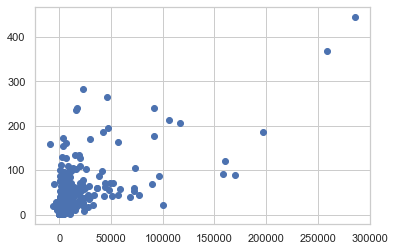

In [143]:
plt.scatter(data_geo['elderlyrealchange'], data_geo['elderlypopdensity19'])

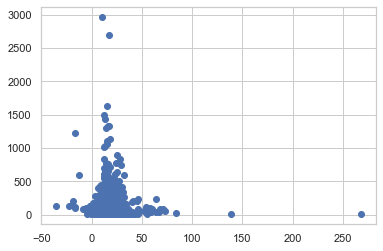

In [145]:
plt.scatter(data_geo['elderlypercchange'], data_geo['popdensity19'])

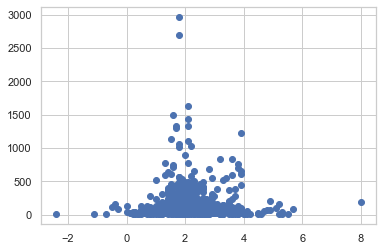

In [146]:
plt.scatter(data_geo['elderlysharechange'], data_geo['popdensity19'])

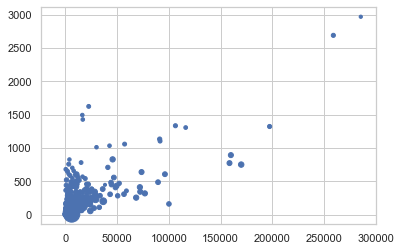

In [150]:
plt.scatter(data_geo['elderlyrealchange'], data_geo['popdensity19'], data_geo['elderlypercchange'])

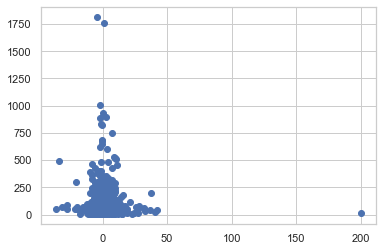

In [137]:
plt.scatter(data_geo['taxbasepercchange'], data_geo['tbdensity19'])

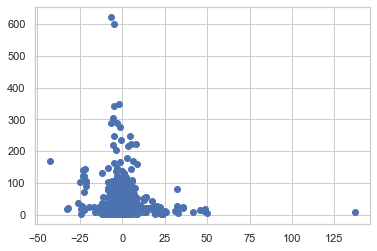

In [138]:
plt.scatter(data_geo['childpercchange'], data_geo['childdensity19'])

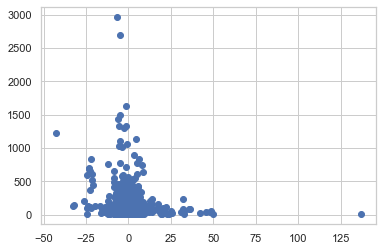

In [139]:
plt.scatter(data_geo['childpercchange'], data_geo['popdensity19'])

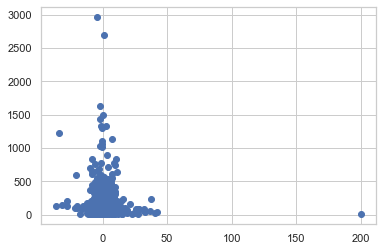

In [140]:
plt.scatter(data_geo['taxbasepercchange'], data_geo['popdensity19'])

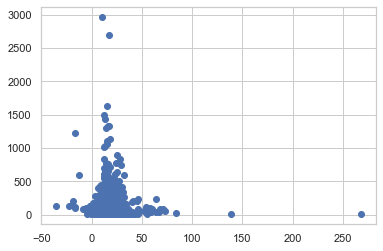

In [141]:
plt.scatter(data_geo['elderlypercchange'], data_geo['popdensity19'])

In [109]:
# plt.scatter(groupperc['elderlypercchange'], groupperc['childpercchange'])

In [110]:
# plt.scatter(groupperc['elderlypercchange'], groupperc['totalpercchange'])

In [151]:
km=KMeans(n_clusters=3)
km

KMeans(n_clusters=3)

In [153]:
Area_predicted = km.fit_predict(data_geo[['elderlysharechange','popdensity19']])
Area_predicted

array([0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 1, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,

In [154]:
data_geo['cluster']= Area_predicted
data_geo.head()

,Micro_Metro,ALAND,AWATER,geometry,CBSA,GEOID,CBSAFIPS,elderlypercchange,taxbasepercchange,childpercchange,...,total,popdensity14,popdensity19,elderlypopdensity14,elderlypopdensity19,tbdensity14,tbdensity19,childdensity14,childdensity19,cluster
0,M1,1024.941767,10.092773,"POLYGON ((-83.53739 33.96591, -83.53184 33.968...","Athens-Clarke County, GA Metro Area",310M500US12020,12020,24.62,3.56,5.21,...,208457,191.510392,191.510392,20.941678,26.097092,131.507959,136.190176,39.060756,41.096969,0
1,M1,555.511664,116.319844,"POLYGON ((-74.85675 39.42076, -74.85670 39.420...","Atlantic City-Hammonton, NJ Metro Area",310M500US12100,12100,13.36,-5.52,-8.40,...,266105,495.624157,495.624157,74.088453,83.989236,309.352640,292.276491,112.183063,102.761119,2
2,M2,362.830511,1.026029,"POLYGON ((-85.19295 41.38001, -85.19296 41.381...","Auburn, IN Micro Area",310M500US12140,12140,14.75,0.17,-2.86,...,42927,116.641238,116.641238,16.280329,18.680899,70.650067,70.768580,29.710842,28.861961,0
3,M2,691.578656,172.087923,"POLYGON ((-76.73797 42.96129, -76.73771 42.961...","Auburn, NY Micro Area",310M500US12180,12180,10.63,-4.31,-7.61,...,77425,114.926913,114.926913,18.574894,20.550085,72.259315,69.144702,24.092704,22.259218,0
4,M1,607.534052,8.311367,"POLYGON ((-85.29322 32.73073, -85.28826 32.730...","Auburn-Opelika, AL Metro Area",310M500US12220,12220,31.07,6.95,5.87,...,161152,243.262085,243.262085,23.478519,30.773584,166.321541,177.879741,53.462024,56.602589,0


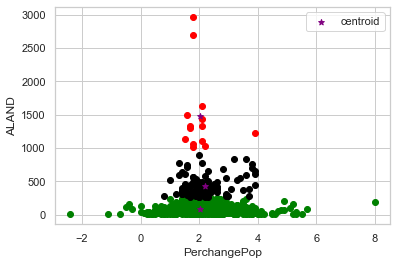

In [156]:
 df1= data_geo[data_geo.cluster==0]
df2= data_geo[data_geo.cluster==1]
df3= data_geo[data_geo.cluster==2]

plt.scatter(df1['elderlysharechange'],df1['popdensity19'], color='green')
plt.scatter(df2['elderlysharechange'],df2['popdensity19'], color= 'red')
plt.scatter(df3['elderlysharechange'],df3['popdensity19'], color= 'black')

plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],color='purple',marker='*',label='centroid')

plt.xlabel('PerchangePop')
plt.ylabel('ALAND')
plt.legend()

In [157]:
import plotly.graph_objects as go

In [158]:
X=data_geo
scaler = MinMaxScaler()
scaler.fit(X)
Z=scaler.transform(X)
inertia = []
for i in range(1,11):
    kmeans = KMeans(
        n_clusters=i, init="k-means++",
        n_init=10,
        tol=1e-04, random_state=42
    )
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
fig = go.Figure(data=go.Scatter(x=np.arange(1,11),y=inertia))
fig.update_layout(title="Inertia vs Cluster Number",xaxis=dict(range=[0,11],title="Cluster Number"),
                  yaxis={'title':'Inertia'},
                 annotations=[
        dict(
            x=3,
            y=inertia[2],
            xref="x",
            yref="y",
            text="Elbow!",
            showarrow=True,
            arrowhead=7,
            ax=20,
            ay=-40
        )
    ])

NameError: name 'MinMaxScaler' is not defined